In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from https://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/
import numpy as np

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

# CelebA

In [ ]:
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import pickle
from scipy.interpolate import griddata

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# load feature file
pkl_file = open('/content/drive/MyDrive/DAI_project/P1/CelebA/celeba_low_1000.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

In [ ]:
print(X[0])
print(y[0])

[1.         0.97156993 0.93585918 0.90730011 0.88668154 0.87383313
 0.85128502 0.84213601 0.81712117 0.79397169 0.78972212 0.78095622
 0.77252383 0.75845672 0.75206792 0.73853648 0.72293952 0.71562084
 0.70232583 0.71227894 0.70433557 0.70091305 0.70064082 0.68723578
 0.68202899 0.68288386 0.67062758 0.6685402  0.66948342 0.66589757
 0.65874992 0.65693388 0.64927026 0.63917264 0.63173125 0.62267583
 0.61457388 0.61597682 0.60954774 0.60351273 0.60151079 0.58908517
 0.58031108 0.57702711 0.56887197 0.5663695  0.56507543 0.55565376
 0.56224332 0.56084094 0.55165516 0.54331105 0.54725375 0.54110297
 0.52959921 0.52930583 0.53031393 0.51352126 0.50623667 0.49477964
 0.49597578 0.50265849 0.49123492 0.48016126 0.48033284 0.46111347
 0.46018334 0.46111148 0.46871861 0.4520409  0.44580526 0.44049955
 0.44895514 0.44840849 0.45387153 0.44419146 0.44781494 0.46015332
 0.45618984 0.44300243]
1.0


We look at the label distribution, to be sure that we have a balanced dataset.

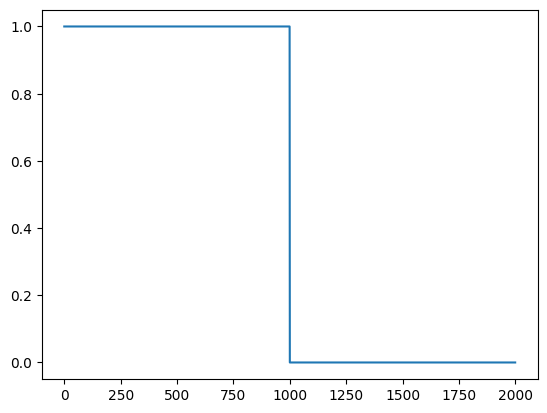

In [ ]:
plt.plot(y)

## spectrum

Text(0, 0.5, 'Power Spectrum')

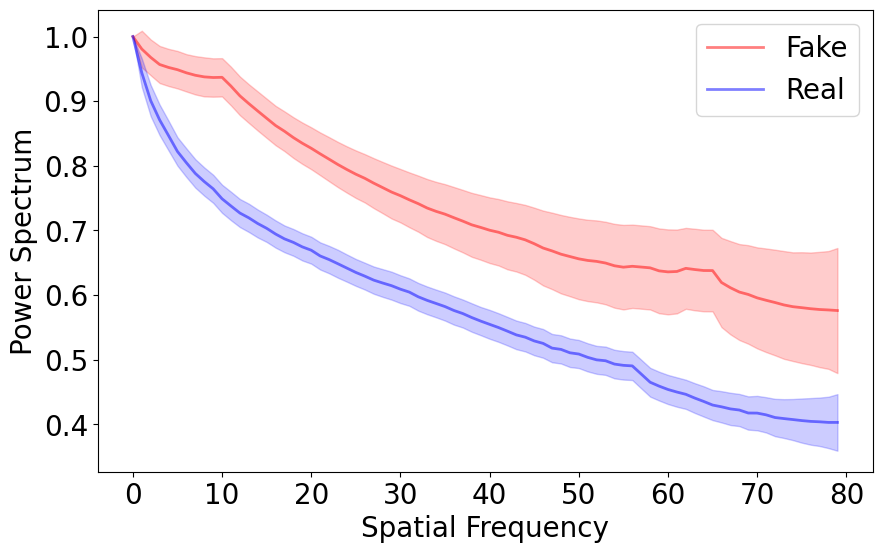

In [ ]:
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])
    
# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)
#plt.savefig('1000_celeba.png', bbox_inches='tight')

## classification

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

num = 10
LR = 0
SVM = 0
SVM_r = 0
SVM_p = 0


for z in range(num):
    # read python dict back from the file
    pkl_file = open('/content/drive/MyDrive/DAI_project/P1/CelebA/celeba_low_1000.pkl', 'rb')
    
    data = pickle.load(pkl_file)

    pkl_file.close()
    X = data["data"]
    y = data["label"]


    try:

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

        from sklearn.svm import SVC
        svclassifier = SVC(kernel='linear')
        svclassifier.fit(X_train, y_train)
        print('Accuracy on test set using linear kernel : {:.3f}'.format(svclassifier.score(X_test, y_test)))
               
        from sklearn.svm import SVC
        svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86)
        svclassifier_r.fit(X_train, y_train)
        print('Accuracy on test set using rbf kernel : {:.3f}'.format(svclassifier_r.score(X_test, y_test)))
                
        from sklearn.svm import SVC
        svclassifier_p = SVC(kernel='poly')
        svclassifier_p.fit(X_train, y_train)
        print('Accuracy on test set using polynomial kernel : {:.3f}'.format(svclassifier_p.score(X_test, y_test)))
        
        from sklearn.linear_model import LogisticRegression
        logreg = LogisticRegression(solver='liblinear', max_iter=1000)
        logreg.fit(X_train, y_train)
        print('Accuracy on test set using logistic reg : {:.3f}'.format(logreg.score(X_test, y_test)))

        
        SVM+=svclassifier.score(X_test, y_test)
        SVM_r+=svclassifier_r.score(X_test, y_test)
        SVM_p+=svclassifier_p.score(X_test, y_test)
        LR+=logreg.score(X_test, y_test)

        
    except:
        num-=1
        print(num)
    

Accuracy on test set using linear kernel : 0.998
Accuracy on test set using rbf kernel : 1.000
Accuracy on test set using polynomial kernel : 1.000
Accuracy on test set using logistic reg : 0.995
Accuracy on test set using linear kernel : 1.000
Accuracy on test set using rbf kernel : 1.000
Accuracy on test set using polynomial kernel : 1.000
Accuracy on test set using logistic reg : 1.000
Accuracy on test set using linear kernel : 0.998
Accuracy on test set using rbf kernel : 1.000
Accuracy on test set using polynomial kernel : 1.000
Accuracy on test set using logistic reg : 0.998
Accuracy on test set using linear kernel : 1.000
Accuracy on test set using rbf kernel : 1.000
Accuracy on test set using polynomial kernel : 1.000
Accuracy on test set using logistic reg : 0.998
Accuracy on test set using linear kernel : 1.000
Accuracy on test set using rbf kernel : 1.000
Accuracy on test set using polynomial kernel : 1.000
Accuracy on test set using logistic reg : 0.998
Accuracy on test set

In [ ]:
print("Average SVM: "+str(SVM/num))
print("Average SVM_r: "+str(SVM_r/num))
print("Average SVM_p: "+str(SVM_p/num))
print("Average LR: "+str(LR/num))

Average SVM: 0.9987499999999999
Average SVM_r: 1.0
Average SVM_p: 1.0
Average LR: 0.9960000000000001


# Faces-HQ

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# load feature file
pkl_file = open('/content/drive/MyDrive/DAI_project/P1/Faces-HQ/dataset_freq_1000.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

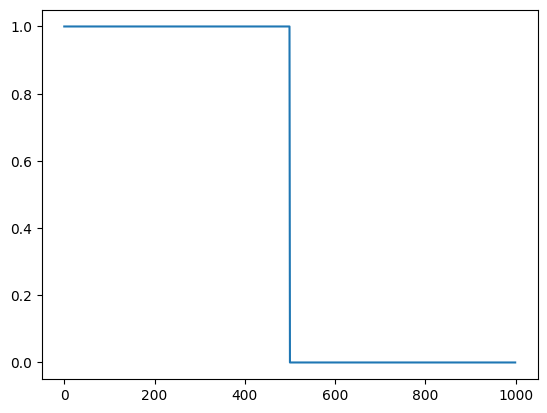

In [ ]:
plt.plot(y)

## spectrum check

Text(0, 0.5, 'Power Spectrum')

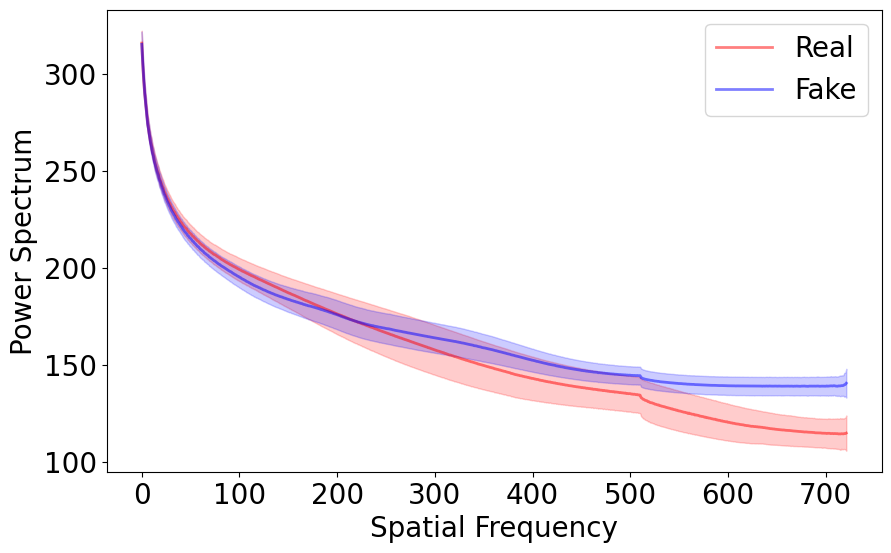

In [ ]:
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])
    
# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)
ax.legend()
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)

## classification

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

num = 10
LR = 0
SVM = 0


for z in range(num):
    # read python dict back from the file
    pkl_file = open('/content/drive/MyDrive/DAI_project/P1/Faces-HQ/dataset_freq_1000.pkl', 'rb')
    
    data = pickle.load(pkl_file)

    pkl_file.close()
    X = data["data"]
    y = data["label"]

    try:

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

        from sklearn.svm import SVC
        svclassifier = SVC(kernel='linear')
        svclassifier.fit(X_train, y_train)
        print('Accuracy on test set: {:.3f}'.format(svclassifier.score(X_test, y_test)))
        
        from sklearn.linear_model import LogisticRegression
        logreg = LogisticRegression(solver='liblinear', max_iter=1000)
        logreg.fit(X_train, y_train)
        print('Accuracy on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

        
        SVM+=svclassifier.score(X_test, y_test)
        LR+=logreg.score(X_test, y_test)

 
    except:
        num-=1
        print(num)
    


Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000


In [ ]:
print("Average SVM: "+str(SVM/num))
print("Average LR: "+str(LR/num))

Average SVM: 1.0
Average LR: 1.0


## Visualization 1d Power Spectrum

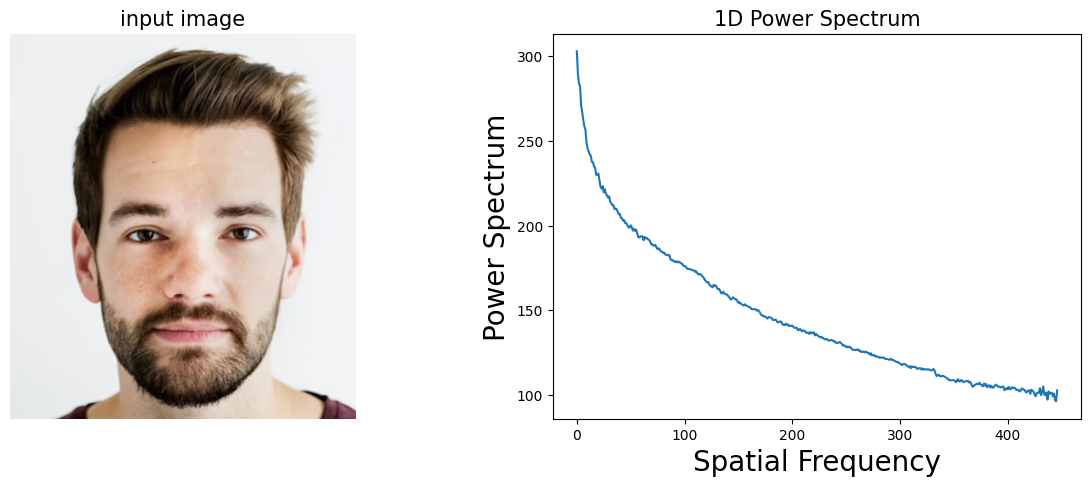

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

epsilon = 1e-8
filename = '/content/drive/MyDrive/DAI_project/P1/Faces-HQ/pic1_faces-HQ.jpeg'

img = cv2.imread(filename,0)
img_color = mpimg.imread(filename)
# Calculate FFT
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
fshift += epsilon
magnitude_spectrum = 20*np.log(np.abs(fshift))
# Calculate the azimuthally averaged 1D power spectrum
psd1D = azimuthalAverage(magnitude_spectrum)

#Visualization
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
plt.axis('off')
ax2 = fig.add_subplot(122)
ax.set_title('input image',size=15)
ax2.set_title('1D Power Spectrum',size=15)
plt.xlabel('Spatial Frequency', fontsize=20)
plt.ylabel('Power Spectrum', fontsize=20)
ax.imshow(img_color)
ax2.plot(psd1D)
plt.show()

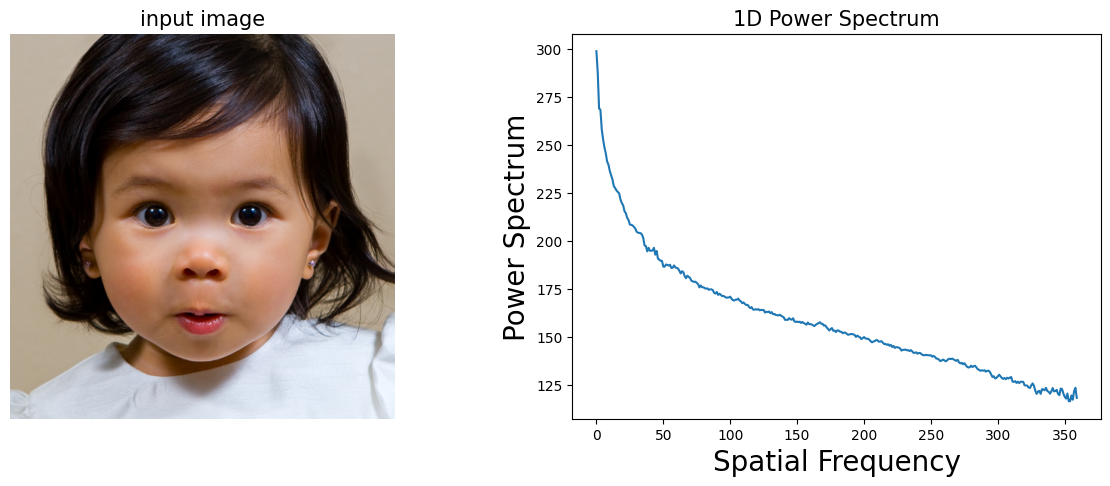

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg


epsilon = 1e-8
filename = '/content/drive/MyDrive/DAI_project/P1/Faces-HQ/ffhq_pic2.png'

img = cv2.imread(filename,0)
img_color = mpimg.imread(filename)
# Calculate FFT
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
fshift += epsilon
magnitude_spectrum = 20*np.log(np.abs(fshift))
# Calculate the azimuthally averaged 1D power spectrum
psd1D = azimuthalAverage(magnitude_spectrum)

#Visualization
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
plt.axis('off')
ax2 = fig.add_subplot(122)
ax.set_title('input image',size=15)
ax2.set_title('1D Power Spectrum',size=15)
plt.xlabel('Spatial Frequency', fontsize=20)
plt.ylabel('Power Spectrum', fontsize=20)
ax.imshow(img_color)
ax2.plot(psd1D)
plt.show()

## Visualization 1d Power Spectrum statistics

In [ ]:
# import cv2
# import numpy as np
# from matplotlib import pyplot as plt
# import glob

# y = []
# error = []

# path = ['thispersondoesntexists_10K/', '100KFake_10K/','Flickr-Faces-HQ_10K/', 'celebA-HQ/']

# for z in range(4):
#     # number of images from each dataset
#     num_images = 10
#     epsilon = 1e-8
#     cont = 0
#     psd1D_org = np.zeros((num_images,722))
#     psd1D_org_mean = np.zeros(722)
#     psd1D_org_std = np.zeros(722)
    

#     for filename in glob.glob(path[z]+"*.jpg"):   

#         img = cv2.imread(filename,0)
#         # Calculate FFT
#         f = np.fft.fft2(img)
#         fshift = np.fft.fftshift(f)
#         fshift += epsilon
#         magnitude_spectrum = 20*np.log(np.abs(fshift))
#         # Calculate the azimuthally averaged 1D power spectrum
#         psd1D = azimuthalAverage(magnitude_spectrum)

#         if cont == num_images:
#             break

#         psd1D_org[cont,:] = psd1D
#         cont +=1

#     for x in range(722):
#         psd1D_org_mean[x] = np.mean(psd1D_org[:,x])
#         psd1D_org_std[x]= np.std(psd1D_org[:,x])

#     x = np.arange(0, 722, 1)
#     y.append(psd1D_org_mean)
#     error.append(psd1D_org_std)

# fig, ax = plt.subplots(figsize=(15, 9))
# ax.plot(x, y[0], alpha=0.5, color='red', label='thispersondoesnotexist (fake)', linewidth =2.0)
# ax.fill_between(x, y[0] - error[0], y[0] + error[0], color='red', alpha=0.2)

# ax.plot(x, y[1], alpha=0.5, color='blue', label='100K Faces (fake)', linewidth = 2.0)
# ax.fill_between(x, y[1] - error[1], y[1] + error[1], color='blue', alpha=0.2)

# ax.plot(x, y[2], alpha=0.5, color='green', label='Flickr-Faces-HQ (real)', linewidth = 2.0)
# ax.fill_between(x, y[2] - error[2], y[2] + error[2], color='green', alpha=0.2)

# ax.plot(x, y[3], alpha=0.5, color='brown', label='CelebA-HQ (real)', linewidth = 2.0)
# ax.fill_between(x, y[3] - error[3], y[3] + error[3], color='brown', alpha=0.2)

# ax.set_title('Satistics 1D Power Spectrum',size=20)
# plt.xlabel('Spatial Frequency', fontsize=20)
# plt.ylabel('Power Spectrum', fontsize=20)
# plt.tick_params(axis='x', labelsize=20)
# plt.tick_params(axis='y', labelsize=20)
# ax.legend(loc='best', prop={'size': 20})
# plt.show()

## visualize high freq elements

In [ ]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius

    return mask

<ipython-input-21-ce8e3b96f9e9>:56: RuntimeWarning: invalid value encountered in true_divide
  inv2 /= inv.max()


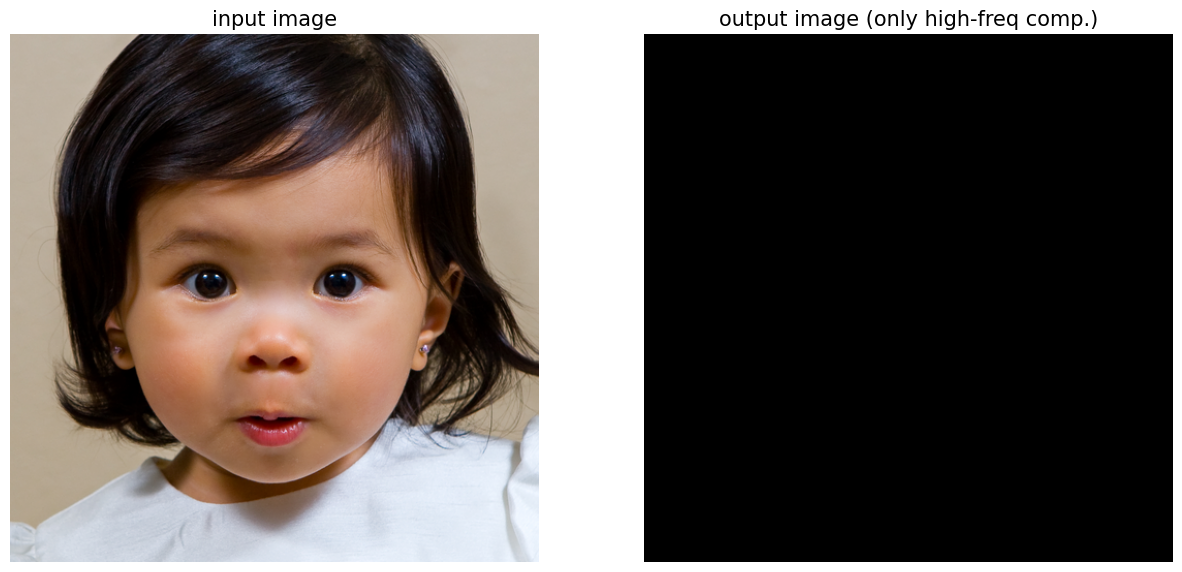

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

import glob

epsilon = 1e-8
filename = '/content/drive/MyDrive/DAI_project/P1/Faces-HQ/ffhq_pic2.png'

mask = create_circular_mask(512,512,radius=500)
mask = np.invert(mask)
inv = np.zeros([512,512,3])
img_color =[]

# Read image and split color-channels
img_color = mpimg.imread(filename)
img_r = img_color[:,:,0]
img_b = img_color[:,:,1]
img_g = img_color[:,:,2]

# Calculate FFT and appply mask for each channel
f_r = np.fft.fft2(img_r)
fshift_r = np.fft.fftshift(f_r)       
fshift_r = fshift_r*mask       
f_ishift_r = np.fft.ifftshift(fshift_r)
img_back_r = np.fft.ifft2(f_ishift_r)
img_back_r = np.abs(img_back_r)

f_b = np.fft.fft2(img_b)
fshift_b = np.fft.fftshift(f_b)
fshift_b = fshift_b*mask   
f_ishift_b = np.fft.ifftshift(fshift_b)
img_back_b = np.fft.ifft2(f_ishift_b)
img_back_b = np.abs(img_back_b)

f_g = np.fft.fft2(img_g)
fshift_g = np.fft.fftshift(f_g)
fshift_g = fshift_g*mask   
f_ishift_g = np.fft.ifftshift(fshift_g)
img_back_g = np.fft.ifft2(f_ishift_g)
img_back_g = np.abs(img_back_g)

inv[:,:,0] = np.round(img_back_r)/255
inv[:,:,1] = np.round(img_back_b)/255
inv[:,:,2] = np.round(img_back_g)/255

# Visualization
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121)
plt.axis('off')
ax2 = fig.add_subplot(122)
plt.axis('off')

# Weightning for enhance visualization
inv2 = np.copy(inv)
inv2 /= inv.max()
inv2 *= 4

ax.set_title('input image',size=15)
ax.imshow(img_color)
ax2.set_title('output image (only high-freq comp.)',size=15)
ax2.imshow(inv2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


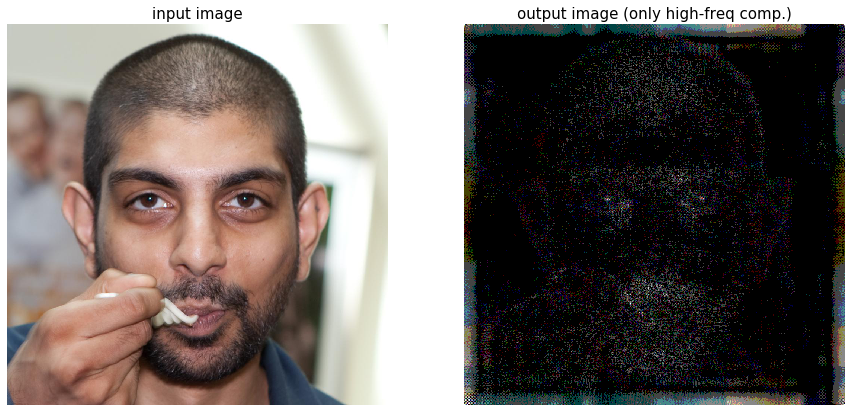

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import glob

epsilon = 1e-8
filename = '/content/drive/MyDrive/DAI_project/P1/Faces-HQ/ffhq_pic4.jpeg'

mask = create_circular_mask(1024,1024,radius=500)
mask = np.invert(mask)
inv = np.zeros([1024,1024,3])
img_color =[]

# Read image and split color-channels
img_color = mpimg.imread(filename)
img_r = img_color[:,:,0]
img_b = img_color[:,:,1]
img_g = img_color[:,:,2]

# Calculate FFT and appply mask for each channel
f_r = np.fft.fft2(img_r)
fshift_r = np.fft.fftshift(f_r)       
fshift_r = fshift_r*mask       
f_ishift_r = np.fft.ifftshift(fshift_r)
img_back_r = np.fft.ifft2(f_ishift_r)
img_back_r = np.abs(img_back_r)

f_b = np.fft.fft2(img_b)
fshift_b = np.fft.fftshift(f_b)
fshift_b = fshift_b*mask   
f_ishift_b = np.fft.ifftshift(fshift_b)
img_back_b = np.fft.ifft2(f_ishift_b)
img_back_b = np.abs(img_back_b)

f_g = np.fft.fft2(img_g)
fshift_g = np.fft.fftshift(f_g)
fshift_g = fshift_g*mask   
f_ishift_g = np.fft.ifftshift(fshift_g)
img_back_g = np.fft.ifft2(f_ishift_g)
img_back_g = np.abs(img_back_g)

inv[:,:,0] = np.round(img_back_r)/255
inv[:,:,1] = np.round(img_back_b)/255
inv[:,:,2] = np.round(img_back_g)/255

# Visualization
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121)
plt.axis('off')
ax2 = fig.add_subplot(122)
plt.axis('off')

# Weightning for enhance visualization
inv2 = np.copy(inv)
inv2 /= inv.max()
inv2 *= 4

ax.set_title('input image',size=15)
ax.imshow(img_color)
ax2.set_title('output image (only high-freq comp.)',size=15)
ax2.imshow(inv2)
plt.show()

# FaceForensics++

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# load feature file
pkl_file = open('/content/drive/MyDrive/DAI_project/P1/FaceForensics++/train_3200.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

We look at the label distribution, to be sure that we have a balanced dataset.

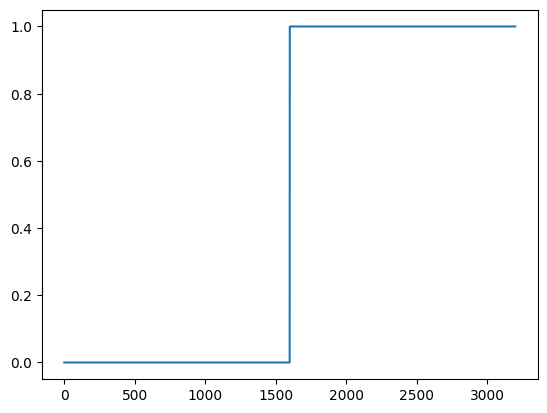

In [ ]:
plt.plot(y)

## check spectrum

Text(0, 0.5, 'Power Spectrum')

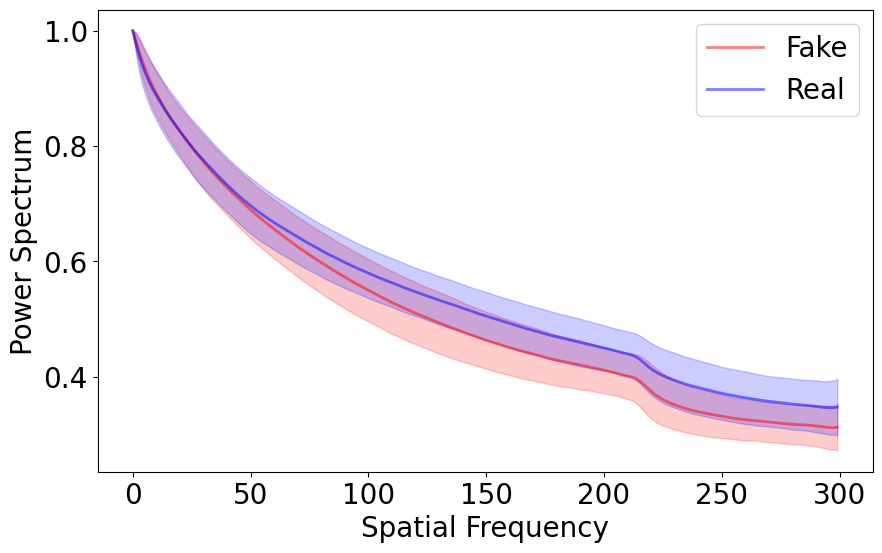

In [ ]:
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])
    
# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)

## classification

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pickle

#train
pkl_file = open('/content/drive/MyDrive/DAI_project/P1/FaceForensics++/train_3200.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86)
svclassifier_r.fit(X, y)
logreg = LogisticRegression(solver='liblinear', max_iter=1000)
logreg.fit(X, y)


LogisticRegression(max_iter=1000, solver='liblinear')

In [ ]:
#test
pkl_file = open('/content/drive/MyDrive/DAI_project/P1/FaceForensics++/test_1000.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X_ = data["data"]
y_ = data["label"]

SVM = svclassifier_r.score(X_, y_)
LR = logreg.score(X_, y_)


print("SVM: "+str(SVM))
print("LR: "+str(LR))

SVM: 0.857
LR: 0.769
